In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from skimage import io

from data_generator import *
from dice_loss import *
from unet import *

from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img
)
print(tf.__version__)

1.14.0


Using TensorFlow backend.


In [2]:
TRAIN_PATH = 'data/train/'
XTRAIN_PATH = f'{TRAIN_PATH}/image'
YTRAIN_PATH = f'{TRAIN_PATH}/label'

TEST_PATH = 'data/test/'
XTEST_PATH = f'{TEST_PATH}/image'
YTEST_PATH = f'{TEST_PATH}/label'

# STEPS=2000
STEPS = 50
EPOCHS=2
# EPOCHS = 1
MODEL_NAME = 'unet_lidc.hdf5'

## Data Generation and Augmentation

In [3]:
image_generator_train = ImageDataGenerator(
    rotation_range=2,
    rescale=1./255,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.0
)

label_generator_train = ImageDataGenerator(
    rotation_range=2,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.0
)

image_generator_test = ImageDataGenerator(
    rescale=1./255,
    fill_mode='reflect',
    data_format='channels_last',
    validation_split=0.0
)

label_generator_test = ImageDataGenerator(
    # No rescale transform on target mask
    fill_mode='reflect',
    data_format='channels_last',
    validation_split=0.0
)

In [4]:
train_generator = generator(
    TRAIN_PATH,
    image_generator_train,
    label_generator_train
)
test_generator = generator(
    TEST_PATH,
    image_generator_test,
    label_generator_test
)

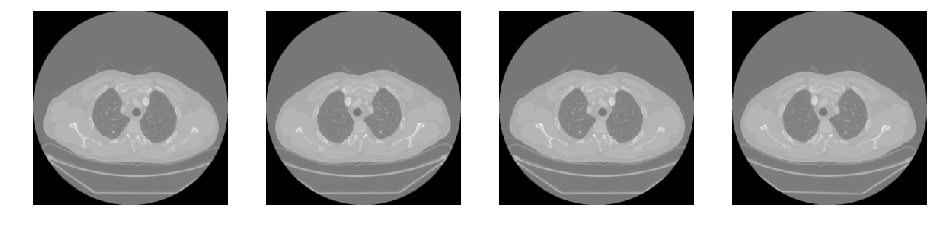

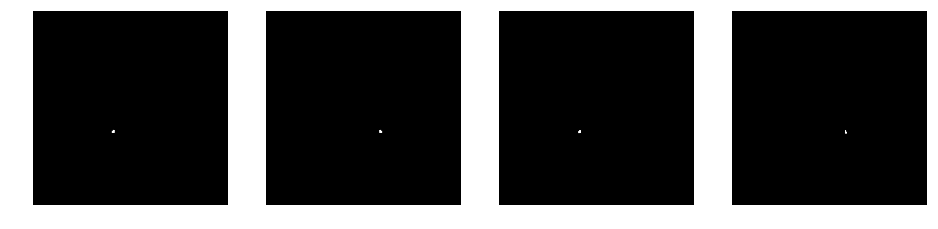

In [5]:
show_augmentation('data/train/image/0.png', image_generator_train, n_rows=1)
show_augmentation('data/train/label/0.png', label_generator_train, n_rows=1)

## Instantiate the U-Net

In [6]:
model = unet()
model.compile(
    optimizer = Adam(lr = 1e-5),
    loss=dice_coef_loss,
    metrics = [
        'accuracy',
        dice_coef,
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.TruePositives()
    ]
)
model_checkpoint = ModelCheckpoint(MODEL_NAME, monitor='loss',verbose=1, save_best_only=True)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Train the U-Net

In [12]:
model.fit_generator(
  train_generator,
  steps_per_epoch = 1000,
  epochs = 5
)

Epoch 1/5
1000/1000 [==============================] - 44s 44ms/step - loss: 1.0000 - acc: 0.1264 - dice_coef: 1.3170e-05 - precision: 0.0021 - recall: 0.9992 - true_negatives: 16564108.0000 - true_positives: 244599.0000
Epoch 2/5
1000/1000 [==============================] - 44s 44ms/step - loss: 1.0000 - acc: 0.5570 - dice_coef: 1.3155e-05 - precision: 0.0028 - recall: 0.6667 - true_negatives: 73003168.0000 - true_positives: 163324.0000
Epoch 3/5
 251/1000 [======>.......................] - ETA: 32s - loss: 1.0000 - acc: 0.9981 - dice_coef: 1.2694e-09 - precision: 0.0000e+00 - recall: 0.0000e+00 - true_negatives: 32837754.0000 - true_positives: 0.0000e+00

KeyboardInterrupt: 

## Test the U-Net

In [10]:
img0 = io.imread('data/test/image/0.png', as_gray=True)
mask0 = io.imread('data/test/label/0.png', as_gray=True)
x = img_to_array(img0)
y = img_to_array(mask0)

result = model.predict(x.reshape(1, 256, 256, 1))
# results = model.predict_generator(train_generator, 2, verbose=1)

# Visualize test results

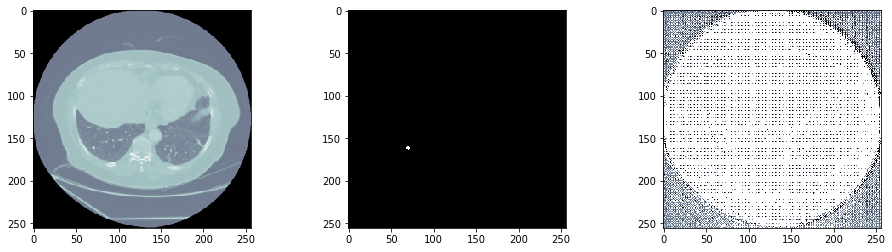

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(x.reshape(256, 256), cmap='bone')
axs[1].imshow(y.reshape(256, 256), cmap='bone')
axs[2].imshow(result.reshape(256, 256), vmin=0, vmax=1, cmap='bone')
plt.show()